# Elastic FWI on Marmousi II using CGG data setup


by Oleg Ovcharenko

oleg.ovcharenko@kaust.edu.sa

KAUST, 2021

In [1]:
import os
import sys
import copy
import glob
import numpy as np
import importlib
import multiprocessing
from F_fwi import bandpass
from F_fwi import *
from F_utils import *
import scipy
import segyio
from scipy import signal, ndimage
from natsort import natsorted
from skimage.transform import rescale, resize
# MAKE SURE THIS POINTS TO WHRE DENISE IS
sys.path.append(os.path.abspath('../'))
import pyapi_denise as api
print(f'Python: {sys.prefix}')
api._cmd(('source /home/plotnips/Madagascar/share/madagascar/etc/env.sh'))
import shared as sd
import loaders as ld
import vis
from IPython.display import clear_output
import m8r as sf
print(sf)
import nest_asyncio
nest_asyncio.apply()

<module 'scipy' from '/home/plotnips/anaconda3/envs/torch2/lib/python3.9/site-packages/scipy/__init__.py'>
Python: /home/plotnips/anaconda3/envs/torch2
source /home/plotnips/Madagascar/share/madagascar/etc/env.sh


In [36]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 100,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 200,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [3]:
importlib.reload(api)
print(os)
root_fwi = './out_for_pasha_marm/fld'
# denise_root = '../den/'
denise_root = '../'
d = api.Denise(denise_root, verbose=1)
# d.parser_report()
d.save_folder = root_fwi
d.set_paths()

<module 'os' from '/home/plotnips/anaconda3/envs/torch2/lib/python3.9/os.py'>
Init Python 3 API for Denise-Black-Edition.
Check binary in ../bin/denise
Parse ../par/DENISE_marm_OBC.inp
Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./outputs/
Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./out_for_pasha_marm/fld


# Get acquitision details

In [4]:
shot_id_min = 60
n_selected_shots = 80
njump_src = 8
shot_id_max = shot_id_min + (n_selected_shots-1) * njump_src

In [5]:
%run ./fwi_shared_check.ipynb

80/80
Before prep:	(80, 648, 3526)
Data cube:	(80, 324, 3000)
Extended cube:	(80, 324, 3100)
[80, 324, 3050] (80, 324, 3000)
[80, 324, 3150] (80, 324, 3100)
25.0
Assume even average spacing between sources
 150.0 m ~ 6 grid nodes
First source:	1125.0 m
Last source:	12950.0 m
150.0
name:	
x	(80,):	min: 1125.0	max: 12975.0
y	(80,):	min: 50.0	max: 50.0
wavelets:	None
z	(80,):	min: 0.0	max: 0.0
nshot:	80
td	(80,):	min: 0.0	max: 0.0
fc	(80,):	min: 8.0	max: 8.0
amp	(80,):	min: 1.0	max: 1.0
angle	(80,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(80,):	min: 1.0	max: 1.0
drec:	25.0 m
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]


In [6]:
vp_baseline = vp.copy()
print(log_idx)
print(vp.shape)
marm_path = os.path.join(root_fwi, 'start/')
os.makedirs(marm_path, exist_ok=True)
print(marm_path)
if not 'marmousi_II_marine.vp' in os.listdir(marm_path):
    # Download Marmousi II model
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.rho -P {marm_path}')

    # Download initial model for FWI
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.rho -P {marm_path}')
def get_vp_vs_rho(vp):
    vp = extend(vp, 15, 0)

    print(f'Reshape {vp.shape} into {wb_taper.shape}...')

    vp = resize(vp, wb_taper.shape, anti_aliasing=True)
    vp = np.where(vp <= 1500.0, 1490.0, vp)
    vp = extend(vp, 0, 264 + 10 * 8)

    # shear velocity, [m/s]
    vs = vp.copy() / (3 ** 0.5)
    vs = np.where(vp < 1.01 * np.min(vp), 0, vs)

    # density, [kg/m3] 
    rho = 1e3*0.3 * vp.copy()**0.25
    rho = np.where(vp < 1.01 * np.min(vp), 1000, rho)
    return vp, vs, rho
def get_vp_vs_rho_no_extend(vp):
    vp = np.where(vp <= 1500.0, 1490.0, vp)
    # shear velocity, [m/s]
    vs = vp.copy() / (3 ** 0.5)
    vs = np.where(vp < 1.01 * np.min(vp), 0, vs)
    # density, [kg/m3] 
    rho = 1e3*0.3 * vp.copy()**0.25
    rho = np.where(vp < 1.01 * np.min(vp), 1000, rho)
    return vp, vs, rho
def F_initial_vz_model_custom(Models,dz,water_sz):
    nx = Models.shape[0];nz = Models.shape[1]
    n1 = Models.shape[0];n2 = Models.shape[1]
    if n1<n2:
        nx=n2
        nz=n1
    else:
        nx=n1
        nz=n2
    # water_sz=(np.where(Models[0,:]==1500))[0].size
    zz = np.arange(nz-water_sz) * dz
    zz = np.tile(zz, (nx, 1))
    init = 1500 + 0.9 * zz
    water=np.ones((nx,water_sz))*1500
    init=np.concatenate([water,init],axis=1)
    # Plot_image(Models.T,Show_flag=0,Save_flag=1,Title='original_model',Save_pictures_path='./pictures_for_check',c_lim=[1500,5000])
    # Plot_image(init.T,Show_flag=0,Save_flag=1,Title='init',Save_pictures_path='./pictures_for_check',c_lim=[1500,5000])
    return init

420
(152, 600)
./out_for_pasha_marm/fld/start/


In [7]:
vp_orig = load_bin(f'{marm_path}marmousi_II_marine.vp', (500, 174))
vs_orig = load_bin(f'{marm_path}marmousi_II_marine.vs', (500, 174))
rho_orig = load_bin(f'{marm_path}marmousi_II_marine.rho', (500, 174))
model_orig = api.Model(vp_orig,vs_orig,rho_orig, dx)
nx0 = 500
limits_vp = {'vmin': model_orig.vp.min() / 1000, 'vmax': model_orig.vp.max() / 1000}
limits_vs = {'vmin': model_orig.vs.min() / 1000, 'vmax': model_orig.vs.max() / 1000}
limits_rho = {'vmin': model_orig.rho.min() / 1000, 'vmax': model_orig.rho.max() / 1000}
print(vp_orig[-30:,33])
# vis.plot_log_model(model_orig.vp, dx, nx0, nz0, src, **limits_vp)
# vp2,vs2,rho2 = get_vp_vs_rho_no_extend(model_orig.vp)

(174, 500)
(174, 500)
(174, 500)
[2178.8213 2172.6975 2166.5737 2160.45   2006.9462 1949.7916 1876.3092
 1837.1172 1500.     1500.     1500.     1500.     1500.     1500.
 1500.     1500.     1500.     1500.     1500.     1500.     1500.
 1500.     1500.     1500.     1500.     1500.     1500.     1500.
 1500.     1500.    ]


In [8]:
vp_marm = load_bin(f'{marm_path}marmousi_II_marine.vp', (500, 174))[:, 100:]
print(vp_marm.min(), vp_marm.max())
print('vp_marm.shape=',vp_marm.shape)
############################### not rescale marmousi velocity range
vp_marm=vp_marm
print(vp_marm.min(), vp_marm.max())
print('vp_marm2.shape=',vp_marm.shape)
vmin_marm = vp_marm.min()
vmax_marm = vp_marm.max()

(174, 500)
1500.0 4766.604
vp_marm.shape= (174, 400)
1500.0 4766.604
vp_marm2.shape= (174, 400)


Reshape (189, 400) into (152, 600)...
model.vp.shape= (152, 944)
model_orig.vp.shape= (174, 500)


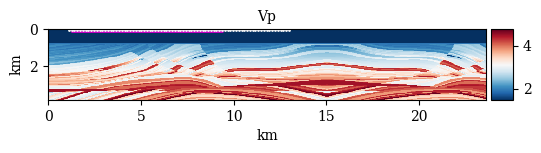

In [60]:
vp, vs, rho = get_vp_vs_rho(vp_marm)
# vis.plot_acquisition(vp, dx, src, rec, title='Vp')
model = api.Model(vp, vs, rho, dx)
# plot_logs(model, model_orig, 111)
print('model.vp.shape=',model.vp.shape)
print('model_orig.vp.shape=',model_orig.vp.shape)

In [ ]:
print(os.getcwd())
prediction_path='../predictions/predictions_1202/model__Marmousi_weights_1202.npz'
with open(prediction_path,'rb') as f:
    data=np.load(f)
    predicted_initial_model=data['predicted_initial_model']
    ideal_initial_model=data['ideal_init_model']
    initial_model_1d=data['models_init']
    MODELS=data['models']
    dx=data['dx']
    dz=data['dz']
    data.close()
np.rot90(MODELS,3)
print(limits_vp)
print(MODELS.shape)
vis.plot_log_model(np.rot90(MODELS,1),dx,nx0=MODELS.shape[0],_src=src,**limits_vp)
# vis.plot_log_model(MODELS,dx, nx0, nz0, src, **limits_vp)

In [17]:
print(dx)

25


## Model prepared by Daniel Kohn from Kiel University

(174, 500)
box_min,box_max= 1500.0 7266.60400390625
Reshape (189, 400) into (152, 600)...
Reshape (189, 400) into (152, 600)...
Reshape (189, 400) into (152, 600)...
Reshape (167, 944) into (152, 600)...
vp_linear.shape= (152, 944)
10500
[2017.87184284 1956.58094259 1922.41035662 2000.52801996 1975.34835374
 1936.30956911 1928.6951816  2001.86994131 1925.37805818 1853.74801033
 1560.99159642 1490.         1490.         1490.         1490.
 1490.         1490.         1490.         1490.         1490.
 1490.         1490.         1490.         1490.         1490.
 1490.         1490.         1490.         1490.         1490.
 1490.         1490.         1490.         1490.         1490.
 1490.         1490.         1490.         1490.         1490.        ]
log.shape= (152,)
log_true_smoothed.shape= (152,)


Text(0.5, 0, 'Depth, km')

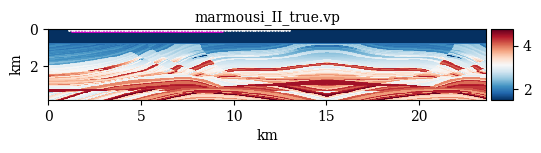

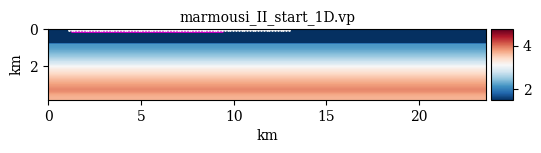

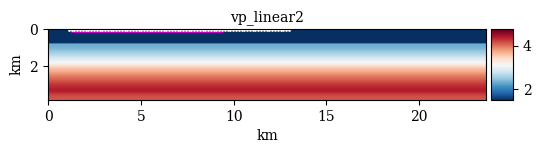

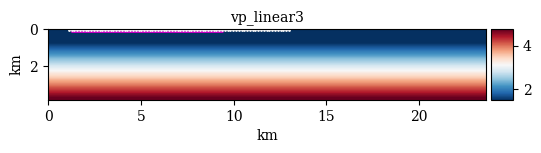

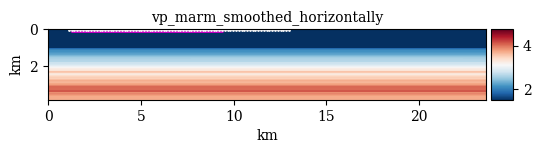

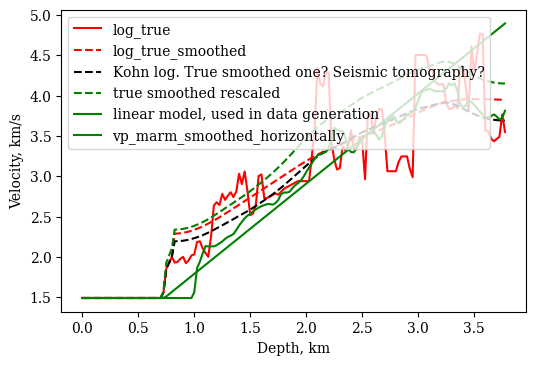

In [71]:
vp_marm_linear = load_bin(f'{marm_path}marmousi_II_start_1D.vp', (500, 174))[:, 100:]

print('box_min,box_max=',box_min,box_max)
box_min = vmin_marm
box_max = vmax_marm+2500
vp_marm_linear2=np.copy(vp_marm_linear)
vp_marm_linear2 -= vmin_marm
vp_marm_linear2 /= vmax_marm
vp_marm_linear2 = box_min  + vp_marm_linear2*(box_max - box_min)

vp_marm_linear3=F_initial_vz_model_custom(vp_marm_linear2,dx,22)

vp_marm_smoothed_horizontally=scipy.ndimage.filters.gaussian_filter1d(model.vp,1000,axis=1)

# print('model.vp.shape=',model.vp.shape)
# print('vp_marm_linear2.shape=',vp_marm_linear2.shape)
# print('vp_marm_linear3.shape=',vp_marm_linear3.shape)

vp_linear, vs_linear, rho_linear = get_vp_vs_rho(vp_marm_linear)
vp_linear2,vs_linear2,rho_linear2= get_vp_vs_rho(vp_marm_linear2)
vp_linear3,vs_linear3,rho_linear3= get_vp_vs_rho(np.rot90(vp_marm_linear3,1))
vp_linear4,vs_linear4,rho_linear4= get_vp_vs_rho(vp_marm_smoothed_horizontally)

model_linear = api.Model(vp_linear, vs_linear, rho_linear, dx)
model_linear2= api.Model(vp_linear2, vs_linear2, rho_linear2, dx)
model_linear3= api.Model(vp_linear3, vs_linear3, rho_linear3, dx)
model_linear4= api.Model(vp_linear4, vs_linear4, rho_linear4, dx)

vis.plot_acquisition(model.vp, dx, src, rec, title='marmousi_II_true.vp',**limits_vp)
vis.plot_acquisition(model_linear.vp, dx, src, rec, title='marmousi_II_start_1D.vp',**limits_vp)
vis.plot_acquisition(vp_linear2, dx, src, rec, title='vp_linear2',**limits_vp)
vis.plot_acquisition(vp_linear3, dx, src, rec, title='vp_linear3',**limits_vp)
vis.plot_acquisition(vp_linear4, dx, src, rec, title='vp_marm_smoothed_horizontally',**limits_vp)

print('vp_linear.shape=',vp_linear.shape)
print(log_idx*dx)
log = model.vp[:, log_idx]
log_linear =  model_linear.vp[:, log_idx]
log_linear2 = model_linear2.vp[:, log_idx]
log_linear3 = model_linear3.vp[:, log_idx]
log_linear4 = model_linear4.vp[:, log_idx]
log_true_smoothed=np.copy(log)
log_true_smoothed[:-33]=scipy.ndimage.filters.gaussian_filter1d(log[:-33],15)
print(log[-40:])
print('log.shape=',log.shape)
print('log_true_smoothed.shape=',log_true_smoothed.shape)
# print(log)
# model_log = copy.deepcopy(model)
log_dict = {'data':log/2, 'loc': log_loc}
# vis.plot_acquisition(vp[:, :500], dx, src, rec, log=log_dict)
# vis.savefig('vinit.png')

fig, ax = plt.subplots(1,1); 
# ax_depth = np.arange(len(wlog)) * dx / 1000
ax_depth = np.arange(len(log)) * dx / 1000
# ax.plot(ax_depth, wlog[::-1] / 1000, 'b', label='CGG')
ax.plot(ax_depth, log[::-1] / 1000, 'r', label='log_true')
ax.plot(ax_depth, log_true_smoothed[::-1] / 1000, 'r--', label='log_true_smoothed')
ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Kohn log. True smoothed one? Seismic tomography?')
ax.plot(ax_depth, log_linear2[::-1] / 1000, 'g--', label='true smoothed rescaled')
ax.plot(ax_depth, log_linear3[::-1] / 1000, 'g', label='linear model, used in data generation')
ax.plot(ax_depth, log_linear4[::-1] / 1000, 'g', label='vp_marm_smoothed_horizontally')
plt.legend(loc='best')
ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')

In [ ]:
wb_taper = np.where(model.vp < 1.01 * model.vp.min(), 1, 0)
nx0 = 500
limits_vp = {'vmin': model.vp.min() / 1000, 'vmax': model.vp.max() / 1000}
limits_vs = {'vmin': model.vs.min() / 1000, 'vmax': model.vs.max() / 1000}
limits_rho = {'vmin': model.rho.min() / 1000, 'vmax': model.rho.max() / 1000}

In [ ]:
mpl.rcParams['figure.dpi']= 90
vis.plot_log_model(vp_linear, dx, nx0, nz0, src, log=log / 2, log_location=log_location,**limits_vp)

## Crop predicted model
Large part of the model (beyond last source) was only to get full-offset seismic data. When running inversion it is not needed so we cut it down

In [ ]:
model_init = copy.copy(model_linear)
# print(model_init)

In [ ]:
print(wlog.shape, vp.shape)

fig, ax = plt.subplots(1,1)
ax.plot(vp[-len(wlog):, log_idx])
ax.plot(model_init.vp[-len(wlog):, log_idx])

## Initial velocity model
Smooth background model with true water bottom and shallow sediments

In [ ]:
# ax = plot_model(np.concatenate((model_init.vp, model_init.vs, model_init.rho), 1))
# plot_logs(model_log, model_init, log_idx)

fig, ax = plt.subplots(1,1); 
# ax_depth = np.arange(len(wlog)) * dx / 1000
ax_depth = np.arange(len(log_linear)) * dx / 1000
ax.plot(ax_depth, log[::-1] / 1000, 'k', label='Well')
ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Ideal initial')
# log_pred = model_init.vp[-len(wlog):, log_idx]
log_pred = model_init.vp[-len(log):, log_idx]
ax.plot(ax_depth, log_pred[::-1] / 1000, 'r', label='Predicted initial')

nwater = 33#33
dummy = np.zeros_like(model.vp)
dummy[-nwater:, :] = 1.
log_taper = np.min(log_pred) + dummy[:, log_idx] * (np.max(log_pred) - np.min(log_pred))
log_taper = np.min(log_pred) + wb_taper[-len(wlog):, log_idx] * (np.max(log_pred) - np.min(log_pred))
# ax.plot(ax_depth, log_taper[::-1]  / 1000, 'b', label='Taper')
# 
# ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Linear')
ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')
ax.grid(True)
ax.legend()

print(len(wlog), model_init.vp.shape, len(model_init.vp[:len(wlog)]))

In [ ]:
plot_logs(model, model_init, log_idx)